In [1]:
%pylab
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


/Users/nwilming/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Ideal observer analysis
----------------------


The task of the observer is to answer the question has the 2nd grating higher confidence. The observer answers with no (high, low confidence) or yes (low, high confidence).

$$
response = \left\{
  \begin{array}{ll}
    -2 : & P(Yes | x_i) <& c-t\\
    -1 : & P(Yes | x_i) <& c\\
    +1 : & P(Yes | x_i)\ge& c\\
    +2 : & P(Yes | x_i)\ge& c+t\\
  \end{array}
\right.
$$

In this case $x_i$ are the contrast samples and $i$ indexes time, $P(Yes|x_i)$ is the probability that 'Yes' is the correct answer and $t$ is the confidence threshold and $c$ is the criterion of the observer. This implies that the observer needs to compute $P(Yes | x_i)$, e.g. the probability that the correct answer is yes. For simplicity I assume that $c=0$ for now. 

$$
\begin{array}{rl}
    P(Yes|x_i) = & P(\mu>0 | x_i)\\
     = & \int_0^{\infty} P(\mu | x_i) d\mu
\end{array}
$$
In our case the observer does neither know $\sigma$ nor $\mu$ of the distribution that generates the samples $x_i$. Calculation of $P(\mu | x_i)$ should take this into account.
$$P(\mu | x_i)= \int_{-\infty}^{\infty} P(\mu | x_i, \sigma)P(\sigma) d\sigma$$

Assuming a Normal-Gamma prior leads to the following solution. First I show the prior:
$$ P(\mu, \lambda) = \mathcal{N}(\mu | \mu_0, (\kappa_0 \lambda)^{-1}) Ga(\lambda | \alpha_0, rate=\beta_0)$$


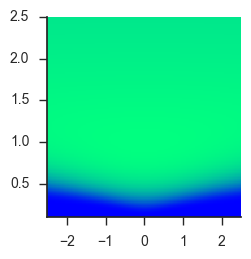

In [271]:
figure(figsize=(2.5, 2.5))
from scipy.stats import norm, gamma

def NG(mu, precision, mu0, kappa0, alpha0, beta0):
    return norm.pdf(mu, mu0, 1./(precision*kappa0)) * gamma.pdf(precision, alpha0, scale=1./beta0)

def p2s(precision):
    return (1./precision)**.5

def s2p(sigma):
    return 1./(sigma**2)

exprior = 0, .1, .1, .1

M, P = meshgrid(linspace(-2.5, 2.5, 150), s2p(linspace(0.1, 2.5, 150)))
pcolor(M, p2s(P), NG(M, P, *exprior), cmap=winter())
xlim([-2.5, 2.5])
ylim([0.1, 2.5])
sns.despine()

With this kind of conjugate prior the posterior also becomes a Normal-Gamma distribution. But for our purpose it is usefull to marginalize out the dependence on $\sigma$ directly, i.e. to compute $P(\mu | x_i)= \int_{-\infty}^{\infty} P(\mu | x_i, \sigma)P(\sigma) d\sigma$.

Luckily enough $P(\mu | x_i)$ then becomes a student-T distribution:
$$ P(\mu | x_i) = \mathcal{t}_{v=2\alpha_n} (\mu | \mu_n, \frac{\beta_n}{\alpha_n \kappa_n})$$ 
The parameters are:
$$
\begin{array}{rl}
    \bar{x} = & \frac{1}{n} \sum_{i=1}^n x_i\\
    \mu_n = & \frac{\kappa_0\mu_0 + n\bar{x}}{2(\kappa_0 + n)}\\
    \kappa_n = & \kappa_0 + n\\
    \alpha_n = & \alpha_0 + n/2\\
    \beta_n = &\beta_0 + \frac{1}{2}\sum_{i=1}^{n} (x_i-\bar{x})^2 + \frac{\kappa_0 n (\bar{x} - \mu_0)^2)}{2(\kappa_0 + n)}
\end{array}
$$

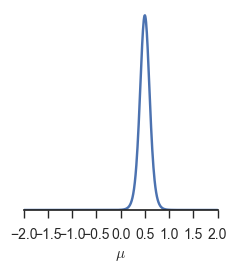

In [3]:
from scipy.stats import t

def data_posterior(data, prior):
    n = len(data)
    xbar = mean(data)
    sigma = std(data)
    return posterior(xbar, sigma, n, prior) 


def NGposterior(xbar, sigma, n, prior):
    '''
    Compute the posterior distribution for n normal samples with mean xbar and std sigma. 
    The prior is given by the quadruple prior (m0, k0, a0, b0) - a Normal-Gamma distribution.
    '''

    mu0, k0, a0, b0 = prior
    mun = (k0*mu0 + n*xbar)/(k0+n)
    kn = k0+n
    an = a0 + (n/2.)
    bn = (b0 + 0.5 *  n*(sigma**2)
                      + (k0*n*((xbar-mu0)**2))
                                  /(2*(k0 + n)))
    return mun, kn, an, bn

def Mu_posterior(xbar, sigma, n, prior):
    '''
    Compute the posterior distribution of mu for n normal samples with mean xbar and std sigma. 
    The prior is given by the quadruple prior (m0, k0, a0, b0) - a Normal-Gamma distribution.
    '''
    mun, kn, an, bn = NGposterior(xbar, sigma, n, prior)
    df = 2*an
    loc = mun
    scale = bn/(an*kn)
    return df, loc, scale

def Sigma_posterior(xbar, sigma, n, prior):
    '''
    Compute the posterior distribution of sigma for n normal samples with mean xbar and std sigma. 
    The prior is given by the quadruple prior (m0, k0, a0, b0) - a Normal-Gamma distribution.
    '''
    mun, kn, an, bn = NGposterior(xbar, sigma, n, prior)
    return an, 1./bn

figure(figsize=(2.5,2.5))
m = linspace(-2, 2, 500)
plot(m, t(*Mu_posterior(.5, 1, 10, exprior)).pdf(m))
xlabel(r'$\mu$')
yticks([])
sns.despine(left=True)

With this we can compute the probability that $\mu\gt 0$. This is simply given by the CDF of the posterior:
$$P(\mu\gt 0| x_i) = 1 - \mathcal{T}(0 | \mu_n, \frac{\beta_n}{\alpha_n \kappa_n})$$

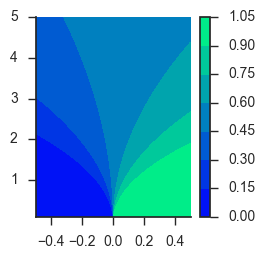

In [4]:
def d_plarger(data, prior):
    t = data_posterior(data, prior)
    return 1-t.cdf(0)

def plarger(mean, std, n, prior):
    df, loc, scale = Mu_posterior(mean.ravel(), std.ravel(), n, prior)
    return 1.-t(df,loc,scale).cdf(0).reshape(mean.shape)

def psmaller(mean, std, n, prior):
    # psmaller is essentially 1-plarger when assuming the same priors for both. 
    # But it is probably more natural to assume that participants have a symmetric
    # prior centered on the threshold. This can be implemented here. I don't do it 
    # at the moment. I leads to strange decision dead zones where the evidence is 0
    # even though the mean difference is quite large. Need to think about what this actually
    # means.
    #prior = (-prior[0], prior[1], prior[2], prior[3])
    df, loc, scale = Mu_posterior(mean.ravel(), std.ravel(), n, prior)
    return t(df,loc,scale).cdf(0).reshape(mean.shape)

figure(figsize=(2.5, 2.5))
M, S = meshgrid(linspace(-.5, .5, 150), linspace(0.1, 5., 150))
contourf(M, S, plarger(M, S, 10, exprior))
xlim([-.5, .5])
sns.despine()
colorbar()

From this we can compute the posterior ratio that participants should answer 'Yes' or 'No':
$$ LPR(x_i) = \frac{P(\mu\gt 0| x_i)} {P(\mu\lt 0| x_i)} = \frac{P(\mu\gt 0| x_i)} {1-P(\mu\lt 0| x_i)} = log P(\mu\gt 0| x_i) - log (1-P(\mu\gt 0| x_i))$$

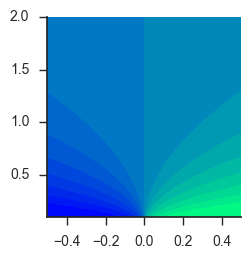

In [5]:
def logLPR(mean, std, prior, debug=False):
    '''
    This gives the log posterior ration. Since probabilities can 
    easily become 0 or 1 I make sure to clip them to 0+eps and 1-eps.
    '''
    mean = asarray(mean)
    std = asarray(std)
    pL = plarger(mean, std, 10., prior)
    pL = maximum(minimum(pL, 1-finfo(float).eps), 0+finfo(float).eps)
    pS = psmaller(mean, std, 10., prior)
    pS = maximum(minimum(pS, 1-finfo(float).eps), 0+finfo(float).eps)
    if debug:
        print 'p<0:', pS, 'p>0:', pL
    return log(pL) - log(pS)

figure(figsize=(2.5, 2.5))
M, S = meshgrid(linspace(-.5, .5, 150), linspace(0.1, 5., 150))
LPR =  logLPR(M, S, exprior)
contourf(M, S, LPR, 15)
xlim([-.5, .5])
ylim([0.1, 2])
sns.despine()

Finding the ideal prior
=======================


In the experiment participants have access to many samples. Can we fit a 'prior' believe by estimating the NG distribution that best estimates these values? 

My first idea was to estimate the generative mean/sigma of a lot of samples and then just the posterior distribution of those samples as a new prior. In this case the precision of the estimated sigma largely determines the shape of the posterior. The larger the precision, the more parallel the posterior becomes.


In [6]:
def get_samples(N=10, thresh=0.25, symmetric=True, vars=[0.05, 0.1, 0.15]):
    if not symmetric:
        return np.concatenate(
              [randn(N, 10)*v + thresh for v in vars])
    else:
        return np.concatenate(
              [randn(N, 10)*v + thresh for v in vars]
             +[randn(N, 10)*v - thresh for v in vars])

-4.25866006961e-05
-4.32891625139e-05


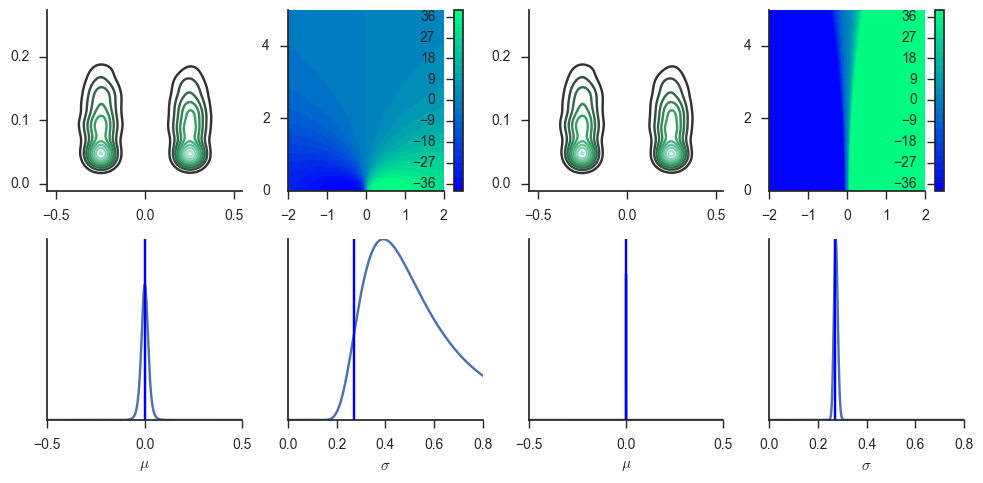

In [273]:

def overview_plot(samples, prior, Nsample=None, gs=None, offset=0):    
    if gs is None:
        gs = matplotlib.gridspec.GridSpec(2,2)
    if Nsample is None:
        Nsample = len(samples)
    mun, kn, an, bn = NGposterior(samples.mean(), samples.std(), Nsample, prior)
    prior = (mun, kn, an, bn)
    posterior_mean = t(2*an, mun, bn/(an*kn))
    posterior_sigma = gamma(an, scale=1./bn)
    subplot(gs[0, offset+0])
    sns.kdeplot(samples.mean(1), samples.std(1))
    pyplot.locator_params(nbins=4)
    
    subplot(gs[0, offset+1])
    M, S = meshgrid(linspace(-2, 2, 500), linspace(0.001, 5, 150))
    LPR =  logLPR(M, S, prior)
    contourf(M, S, LPR, 25)
    colorbar()
    #axvline(mun, color='k')
    #axvline(-mun, color='k')
    pyplot.locator_params(nbins=4)

    subplot(gs[1, offset+0])
    x = linspace(-.5, .5, 10000)
    plot(x, posterior_mean.pdf(x))
    xlabel(r'$\mu$')
    pyplot.locator_params(nbins=4)
    yticks([])
    axvline(samples.mean())
    subplot(gs[1, offset+1])
    x = s2p(linspace(0.001,  0.8, 1000))
    yticks([])
    plot(p2s(x), posterior_sigma.pdf(x))
    xlabel(r'$\sigma$')
    pyplot.locator_params(nbins=4)
    sns.despine()
    axvline(samples.std())
    tight_layout()
    print mun

figure(figsize=(10, 5))
gs = matplotlib.gridspec.GridSpec(2, 4)
samples = get_samples(N=600, symmetric=True)
overview_plot(samples, exprior, Nsample=6, gs=gs)
overview_plot(samples, exprior, gs=gs, Nsample=600, offset=2)

Why does this happen? The posterior is defined by $log(P(\mu>0| x_i)) - log(P(\mu<0| x_i))$ and since the two probabilities are 1-each other, it is enough to look at one of the two in these two situations. The posterior $\mu$ distribution is 
$$P(\mu|x_i) = \mathcal{t}_{2\alpha_n} (\mu | \mu_n, \beta_n / (\alpha_n \kappa_n))$$
All of these parameters depend on the prior:

$$
\begin{array}{rl}
    \mu_n = & \frac{\kappa_0\mu_0 + n\bar{x}}{2(\kappa_0 + n)}\\
    \kappa_n = & \kappa_0 + n\\
    \alpha_n = & \alpha_0 + n/2\\
    \beta_n = &\beta_0 + \frac{1}{2}\sum_{i=1}^{n} (x_i-\bar{x})^2 + \frac{\kappa_0 n (\bar{x} - \mu_0)^2)}{2(\kappa_0 + n)}
\end{array}
$$

So we can ask how the posterior distribution changes when the prior changes. Let's do a little experiment. We keep sigma, mean and prior the same and see what happends when the sample size changes:

(-7.2780603050619699e-05, 6.01, 3.01, 0.2317576564857953)
(-7.2900689044219993e-05, 600.01, 300.01, 22.185765645953182)


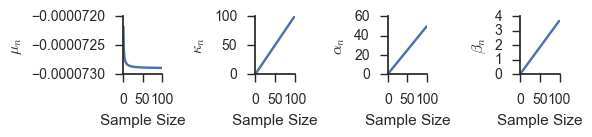

In [8]:
uncertain = NGposterior(samples.mean(), samples.std(), 6, exprior)
certain = NGposterior(samples.mean(), samples.std(), 600, exprior)
print uncertain
print certain
ss = arange(1, 100)
figure(figsize=(6, 1.5))
values = [NGposterior(samples.mean(), samples.std(), s, exprior) for s in ss]
labels = [r'$\mu_n$', r'$\kappa_n$', r'$\alpha_n$', r'$\beta_n$']
for i,p in enumerate(array(values).T):
    subplot(1,4,i+1)
    _=plot(ss, p)
    pyplot.locator_params(nbins=4)
    xlabel('Sample Size')
    ylabel(labels[i])
sns.despine()
tight_layout()

So in a way, if we change the sample size we simply scale $\kappa_0$, $\alpha_0$ and $\beta_0$ with the sample size. The parameters for the posterior are:
$$
\begin{array}{rl}
    df = & 2\alpha_n = 2 \alpha_0 + n/2\\
    loc = & \mu_n = \frac{\kappa_0\mu_0 + n\bar{x}}{\kappa_0 + n}\\
    scale = & \frac{\beta_n}{\alpha_n \kappa_n} 
\end{array}
$$
The df parameter will increase with certainty, which implies that the $\mathcal{t}$ distribution becomes more and more normal. The location parameter will be closer and closer to the prior $\mu$ with an increase in sample size in the prior, the size of this bias depends on $\kappa_0$. The scale parameter depends in a non straightforward way on the uncertainty because $\beta_n$ depends on $\beta_0$ and $\kappa_0$. But it definetly decreases with certainty. This creates a situation where the posterior becomes more normal, closer to the prior mean with certainty in the prior and less variability. We can use these properties to explain the features of the log PR space plotted above. For high uncertainty in the prior, the mean of the posterior is close to the sample mean and the uncertainty is comparably large. For high certainty the situation should be reversed. If we were to plot the mean of the posterior for high and low uncertainty in the prior, we would confirm that the mean moves strongly with the sample mean in the high uncertainty case but almost not at all in the high certainty case. Conversely, the sigma of the posterior is very low and almost independent of the sample sigma in the high certainty case but not in the high uncertainty case. 

A full decision model
=====================

In a first step I will implement an ideal observer that gets trials and decides what to do. The observe might choose to update the prior, know the 'true' prior beforehand and might use different but symmetric priors for each option.

In [145]:
class IdealObserver(object):
    def __init__(self, bias, conf_threshold, prior=None):
        self.bias=bias
        self.conf_threshold = conf_threshold
        self.prior = prior
        if prior is None:
            self.prior = 0, .01, .01, .01
        
        
    def __call__(self, mean, sigma, index=False):
        LPR = logLPR(mean, sigma, self.prior)-self.bias
        confidence = 1 + (abs(LPR) >  self.conf_threshold)
        choice = sign(LPR)
        choice[choice==0]+=1
        if not index:            
            return choice*confidence
        else:
            index = choice*confidence+2
            index[index>1] -= 1
            return index
            
    def p(self, mean, sigma):
        '''
        Return multinomial probability vector for samples.
        '''
        decision = self(mean, sigma, index=True)
        ps = ones((4, len(decision)))*0 + 0.01
        for i, idx in enumerate(decision):
            ps[idx, i] = 1
        return ps/ps.sum(0)
        

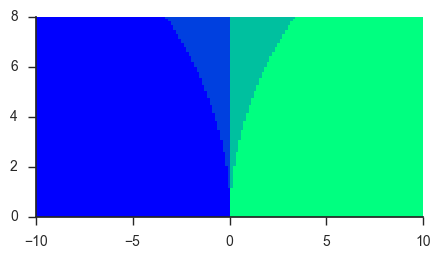

In [286]:
figure(figsize=(5, 2.5))
M, S = meshgrid(linspace(-10, 10, 150), linspace(0.001, 8, 150))
p = array(uncertain)
p[0] = .0
obs = IdealObserver(bias=0, conf_threshold=log(3.5), prior=p)
D = obs(M.ravel(), S.ravel()).reshape(M.shape)
pcolor(M, S, D)
pyplot.locator_params(nbins=4)
sns.despine()

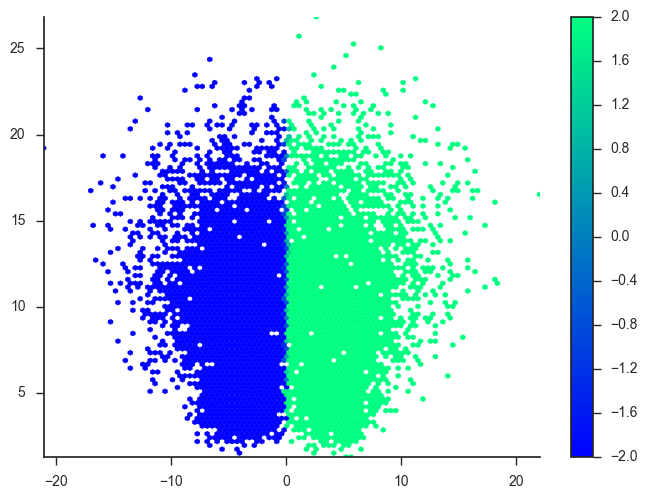

In [259]:
obs = IdealObserver(bias=0, conf_threshold=log(1.5), prior=certain)
samples = get_samples(N=2000, thresh=4,  symmetric=True, vars=[5, 10,  15])
m, s = samples.mean(1), samples.std(1)
d = obs(m, s)
hexbin(m,s,d)
sns.despine()
colorbar()

I now want to fit this model to behavioral data. In total this model has six parameters (the parameter vector shall be called $\theta$). A confidence threshold, bias and the four paramters for the prior. How can we determine these parameters? Maybe we can treat the answer as coming from a multinomial distribution where the probabilities ($\pi_i$) for the four answers a given by the model. This would allow us to define a likelihood function for computing $P(D| \theta)$. I think the key question would be to decide if there is noise in the system. A good diagnostic for noise in the system would be if the same input leads to specific outputs with a certain probability. 

In [260]:
from scipy.special import gammaln

def multinomial(xs, ps):
   """
   Return the probability to draw counts xs from multinomial distribution with
   probabilities ps.

   Returns:
       probability: float
   """
   xs, ps = array(xs), array(ps)
   n = sum(xs)

   result = gammaln(n+1) - sum(gammaln(xs+1)) + sum(xs * log(ps))
   return -result

def err_fct(parameters, true, data):
    obs = IdealObserver(bias=parameters[0], conf_threshold=log(parameters[1]), prior=parameters[2:])
    answers = ones((4, len(true)))*0
    for i, idx in enumerate(true):
        answers[idx, i] = 1
    ps = obs.p(data[0], data[1])
    return sum([multinomial(a,p) for a, p in zip(answers.T, ps.T)])

In [261]:
d2 = obs(samples.mean(1), samples.std(1))+2
d2[d2>1] -= 1
answers = d2
data = (samples.mean(1), samples.std(1))
err_fct([0, 2.5]+list(uncertain), answers, data)

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


21335.860994260282

In [200]:
from scipy.optimize import minimize

In [263]:
err = lambda x: err_fct(x, answers, data)
x = minimize(err, [1, 1, 0, 1, 1, 1], method='Nelder-Mead')

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [268]:
bias = x.x[0]
cutoff = x.x[1]
prior = x.x[2:]
print '%2.4f, %2.4f || %2.4f, %2.4F, %2.4f, %2.4f'%(0, 2.5, certain[0], certain[1], certain[2], certain[3])
print '%2.4f, %2.4f || %2.4f, %2.4F, %2.4f, %2.4f'%(bias, cutoff, prior[0], prior[1], prior[2], prior[3])

0.0000, 2.5000 || -0.0001, 600.0100, 300.0100, 22.1858
-0.0080, 0.9879 || -0.0005, 1.1395, 1.2618, 1.3101


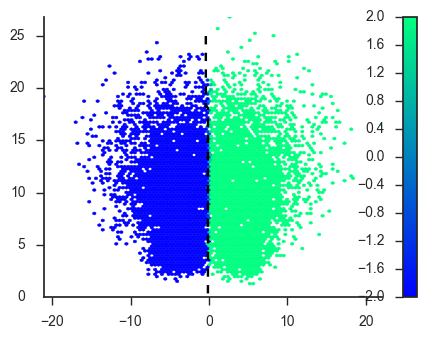

In [269]:
figure(figsize=(12, 3.5))
M, S = meshgrid(linspace(-20, 20, 150), linspace(0.001, 25, 150))

subplot(1,2,1)
obs = IdealObserver(bias=0, conf_threshold=log(1.5), prior=cer  tain)
m, s = samples.mean(1), samples.std(1)
d = obs(m, s)
hexbin(m,s,d)
sns.despine()
colorbar()

obs = IdealObserver(bias=bias, conf_threshold=log(cutoff), prior=prior)
d = obs(M.ravel(), S.ravel()).reshape(M.shape)

print contour(M, S, d, unique(d), zorder=1, colors='k', ls='-')
sns.despine()


The predictive distribution
===========================


(6000,)
6000.02 0.106571621835 0.106546796126


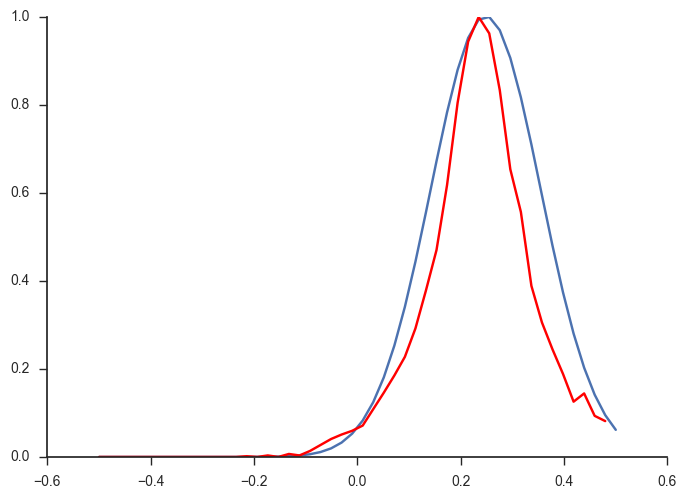

In [12]:
samples = get_samples(200, symmetric=False, vars=[0.05, .1, 0.15]).ravel()
print samples.shape
#m, s = samples.mean(1), samples.std(1)

mun, kn, an, bn = NGposterior(samples.mean(), samples.std(), len(samples), exprior)
kn1 = kn+1
an1 = an+.5
bn1 = bn + ( (kn*(samples.mean()-mun)**2)/(2*(kn+1)))

loc = mun
df = 2*an
scale = (an*kn)/(bn*(kn+1))
print df, p2s(scale), samples.std()
tpred = t(df, loc, p2s(scale))
x= linspace(-.5, .5, 50)
y = tpred.pdf(x)
plot(x, y/y.max())
yy = histogram(samples, bins=x)[0]
ctrs = x[1:] - diff(x)[0]
plot(ctrs, yy/float(max(yy)), 'r-')
sns.despine()

Analysis idea: Variance misperception should evolve with the prior, a.k.a the number of samples seen.